This code will perform the overparameterisation analysis and plot the figures as presented in Figure 3 in the manuscript

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.linear_model import Ridge

#Ignore warnings from Linear regression
import warnings 
warnings.filterwarnings( "ignore" )

In [2]:
def load_data(folder, datalen):
    array_init=False
    
    ## Loop through data files in each folder
    for file in os.listdir(folder):
        if '.npy' in file:
            
            # Load the data
            data=np.load(os.path.join(folder,file),allow_pickle=True)
            
            #Seperate states and input fields
            states = data[:datalen,:-1]
            input_ = data[:datalen,-1].reshape(-1,1)
            
            # Initialise the array for all states
            if array_init==False:
                data_all = states
                input_all = input_



                array_init = True
            else:
                if len(data)>(datalen-1):
                    data_all=np.concatenate([data_all[:datalen],data[:datalen]],axis=1)
                    input_all=np.concatenate([input_all[:datalen],input_[:datalen]],axis=1)
                else:
                    print('File has less data than required - ', file)
    return data_all, input_all
                    
                    

def Overparameterisation_regression(folder,input_signal,tasks,penalty=0,
                                    ntrials=50,iterations=200, trainsize=50,testsize = 50,cross_val=1,
                                   savdirname = 'Results', save_pred = False):
    '''
    This function will perform ridge or linear regression when randomly adding features from a specified network
    folder: the folder containing the data for a certain hierarchy
    input_signal: the original input signal - used for plotting the train and test predictions
    tasks: an array of tasks to be trialled
    penalty: Penalty term for the ridge regression. 0 = linear regression, >0 = Ridge regression
    ntrials: the number of random trails to be performed i.e. how many shuffles of the readout parameters
    iterations: the number of iterations per trial i.e. for each shuffle, how many different numbers of training parameters do we trial
    trainsize: size of the training dataset
    testsize: size of the testing dataset
    cross_val: how many repeats with different portions of training and testing data
    savdirname: name of the folder to save the data to
    save_pred: if True, the predictions from every trial will be saved for later plotting.
    '''
    # Create a subfolder for saving the data
    savdir=os.path.join(folder,savdirname)
    if os.path.isdir(savdir) is False:
        os.mkdir(savdir)
    
    # Load the data
    states, inputs = load_data(folder,datalen=250)
    
    
    # Set the random seeds
    seeds = np.arange(ntrials)
    
    # Loop through tasks
    
    for taskID in range(len(tasks)):
        print('Task: '+str(taskID))
        task = tasks[taskID]
        # Initilase the arrays for storing the train and test MSEs
        trainMSE = np.zeros((len(seeds),iterations,cross_val))
        testMSE = np.zeros((len(seeds),iterations,cross_val))
        
        Ztr_all = np.zeros((len(seeds),iterations,cross_val,trainsize))
        Zte_all = np.zeros((len(seeds),iterations,cross_val,testsize))
        channelssave = np.zeros((len(seeds),iterations,cross_val))
        for n_Cros in np.arange(cross_val):
            
            
            train_starts = np.roll(np.linspace(0,250-trainsize-testsize,cross_val),-n_Cros)
            train_start,test_start = int(train_starts[0]),int(train_starts[0]+trainsize)
            print('Ncros',n_Cros)
            for x in range(len(seeds)):
                #Set the random seed
                np.random.seed(seeds[x])

                # Create an array with values up to the number of channels
                rands = np.arange(len(states[0]))
                
                # Shuffle the channels
                np.random.shuffle(rands)
                
                # Loop through the iterations
                for i in range(1,iterations):
                    ## Select the channels
                    n_channels = int((i/iterations)*len(rands))
                    if n_channels ==0:
                        n_channels=1
                        #return 'Error: Number of iterations is bigger than the number of channels'
                        
                    ## Get the random channels indicies
                    channels = rands[:n_channels]

                    # Only select the correct channels
                    states_reduced = states[:,[channels]][:,0,:]

                    # Split the data into train and test
                    Xtr, Xte, Ytr, Yte = (states_reduced[train_start:train_start+trainsize], 
                                          states_reduced[train_start+trainsize:train_start+trainsize+testsize],
                                         task[train_start:train_start+trainsize],
                                         task[train_start+trainsize:train_start+trainsize+testsize])
                    
                    # Define the model
                    model = Ridge(alpha=penalty)
                     
                    # Fit the training data
                    model.fit(Xtr, Ytr)
                    
                    # Predict the train and test sets
                    Ztr = model.predict(Xtr)
                    Zte = model.predict(Xte)
                    
                    # Get the MSE between predicted and true
                    MSETr = np.sum((Ytr-Ztr)**2)/len(Ytr)
                    MSETe = np.sum((Yte-Zte)**2)/len(Yte)
                    
                    if save_pred == True:
                        Ztr_all[x][i][n_Cros] = np.array(Ztr)
                        Zte_all[x][i][n_Cros] = np.array(Zte)

                    # Append MSE's to array
                    trainMSE[x][i][n_Cros] = MSETr
                    testMSE[x][i][n_Cros] = MSETe
                    channelssave[x][i][n_Cros] = n_channels
                    
        # Save the MSEs
        np.save(os.path.join(savdir,'MSETr_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.npy'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)),trainMSE)
        np.save(os.path.join(savdir,'MSETe_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.npy'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)),testMSE)
        np.save(os.path.join(savdir,'Channels_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.npy'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)),channelssave)
        
        # Save the predictions
        if save_pred == True:
            np.save(os.path.join(savdir,'ZTr_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.npy'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)),Ztr_all)
            np.save(os.path.join(savdir,'ZTe_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.npy'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)),Zte_all)

        
        # Plot the MSE vs number of training features, averaged across n trials and n cross validations
        x = channelssave[0,1:,0]

        fig,ax = plt.subplots(2)
        ax[0].set_title('Task '+str(taskID))
        TrMSEmean = trainMSE[:,1:].mean(axis=2).mean(axis=0)
        TrMSEstd = trainMSE[:,1:].std(axis=0).mean(axis=1)
        TeMSEmean = testMSE[:,1:].mean(axis=2).mean(axis=0)
        TeMSEstd = testMSE[:,1:].std(axis=0).mean(axis=1)

        ax[0].semilogy(x,TrMSEmean,c='k',label = 'Train')
        ax[0].fill_between(x,TrMSEmean-2*TrMSEstd,TrMSEmean+2*TrMSEstd,alpha=0.5,facecolor='k')
        ax[0].set_xscale('log')
        ax[1].semilogy(x,TeMSEmean,c='r',label = 'Test')
        ax[1].fill_between(x,TeMSEmean-2*TeMSEstd,TeMSEmean+2*TeMSEstd,alpha=0.5,facecolor='r')
        ax[1].set_xscale('log')
        ax[0].legend()
        ax[1].legend()

        ax[1].set_xlabel('Number of FMR channels')
        ax[1].set_ylabel('MSE')
        plt.savefig(os.path.join(savdir,'MSETr_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_{}_crossval_{}.png'
                             .format(penalty,taskID,ntrials,iterations,trainsize,testsize,cross_val)))
        plt.close()

        
    


In [3]:
## Load the Mackey Glass signal
base = os.path.split(os.getcwd())[0]
MG = np.load(os.path.join(base,'mackey_glass_t17.npy'))
MG_new = []
for i in range(500):
    MG_new.append(MG[2*i])
MG_new =  (MG_new-np.min(MG_new))/(np.max(MG_new)-np.min((MG_new)))

# Define the delays and make the list of tasks
delays = [1,3,5,7,9,11]
tasks = []
for delay in delays:
    tasks.append(MG_new[delay:])

# Call the function. Results will save to a new folder.
penalties = [0,1e-4]
folder = os.path.join(base,r'Data/Mackey_Glass')
folderlist = []
for type_ in os.listdir(folder):
    typefolder = os.path.join(folder,type_)
    if os.path.isdir(typefolder):
        for network in os.listdir(typefolder):
            netfold = os.path.join(typefolder,network)
            if os.path.isdir(netfold) and 'Clean_data' not in netfold:
                folderlist.append(netfold)

for netfold in folderlist:


    for trainsize in [50,100,150,200]:
        
        for penality in penalties:
            Overparameterisation_regression(netfold,input_signal = MG_new,tasks=tasks,penalty=penality,
                                                ntrials=50,iterations=500, trainsize=trainsize,testsize = 50,cross_val=5,
                                            savdirname = 'OP',save_pred = False)


Task: 0
Ncros 0


KeyboardInterrupt: 

PLOTS

Data_results\Mackey_Glass\Single\WM
Data_results\Mackey_Glass\Parallel\Pall
Data_results\Mackey_Glass\Series\S34
Data_results\Mackey_Glass\Series\S45
Data_results\Mackey_Glass\PNN\All
File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy
Data_results\Mackey_Glass\Single\WM
Data_results\Mackey_Glass\Parallel\Pall
Data_results\Mackey_Glass\Series\S34
Data_results\Mackey_Glass\Series\S45
Data_results\Mackey_Glass\PNN\All
File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy


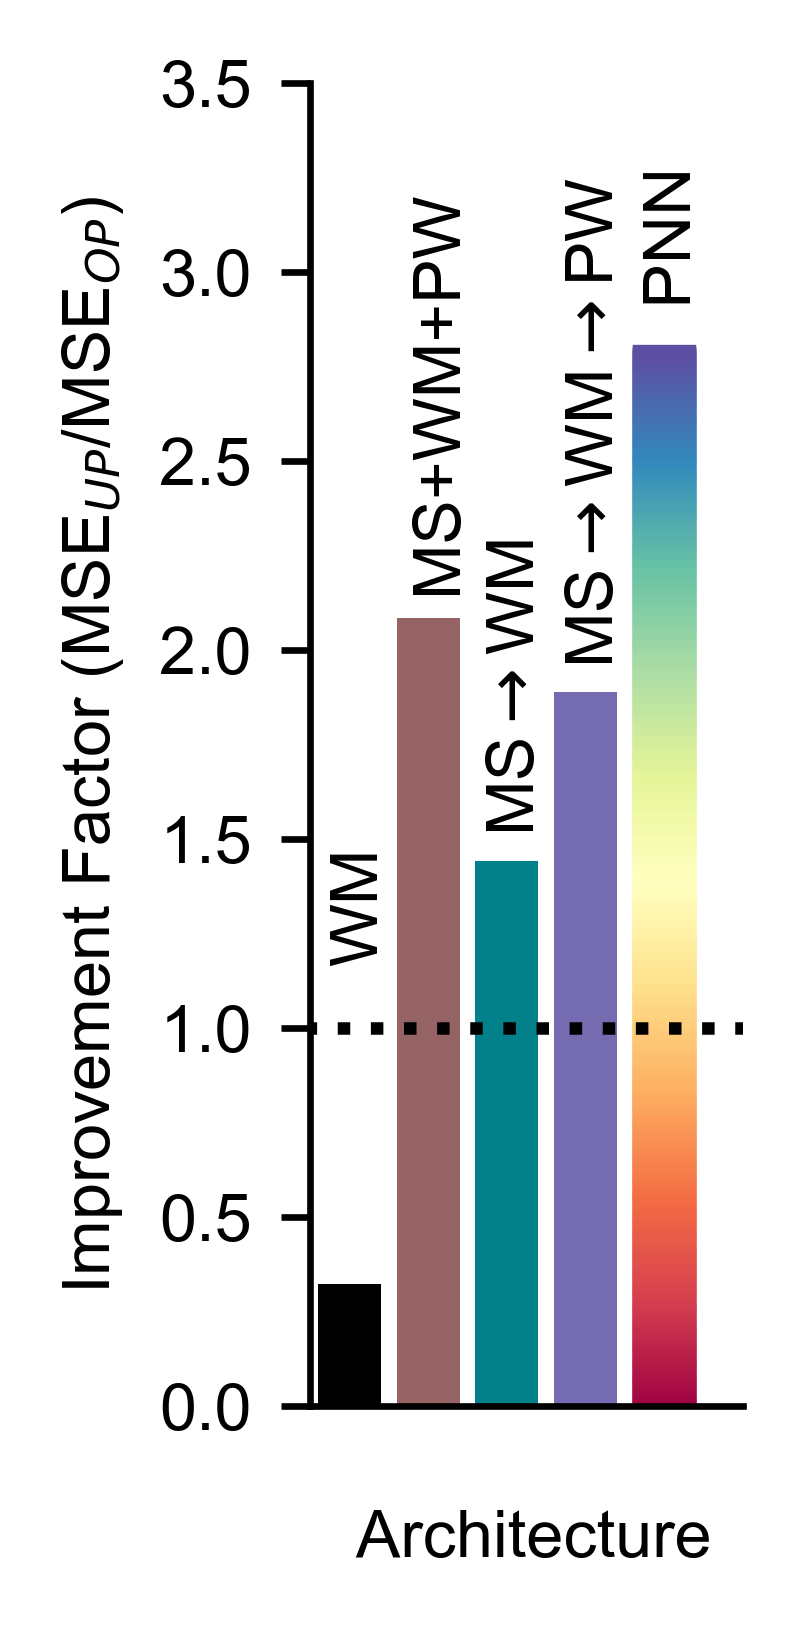

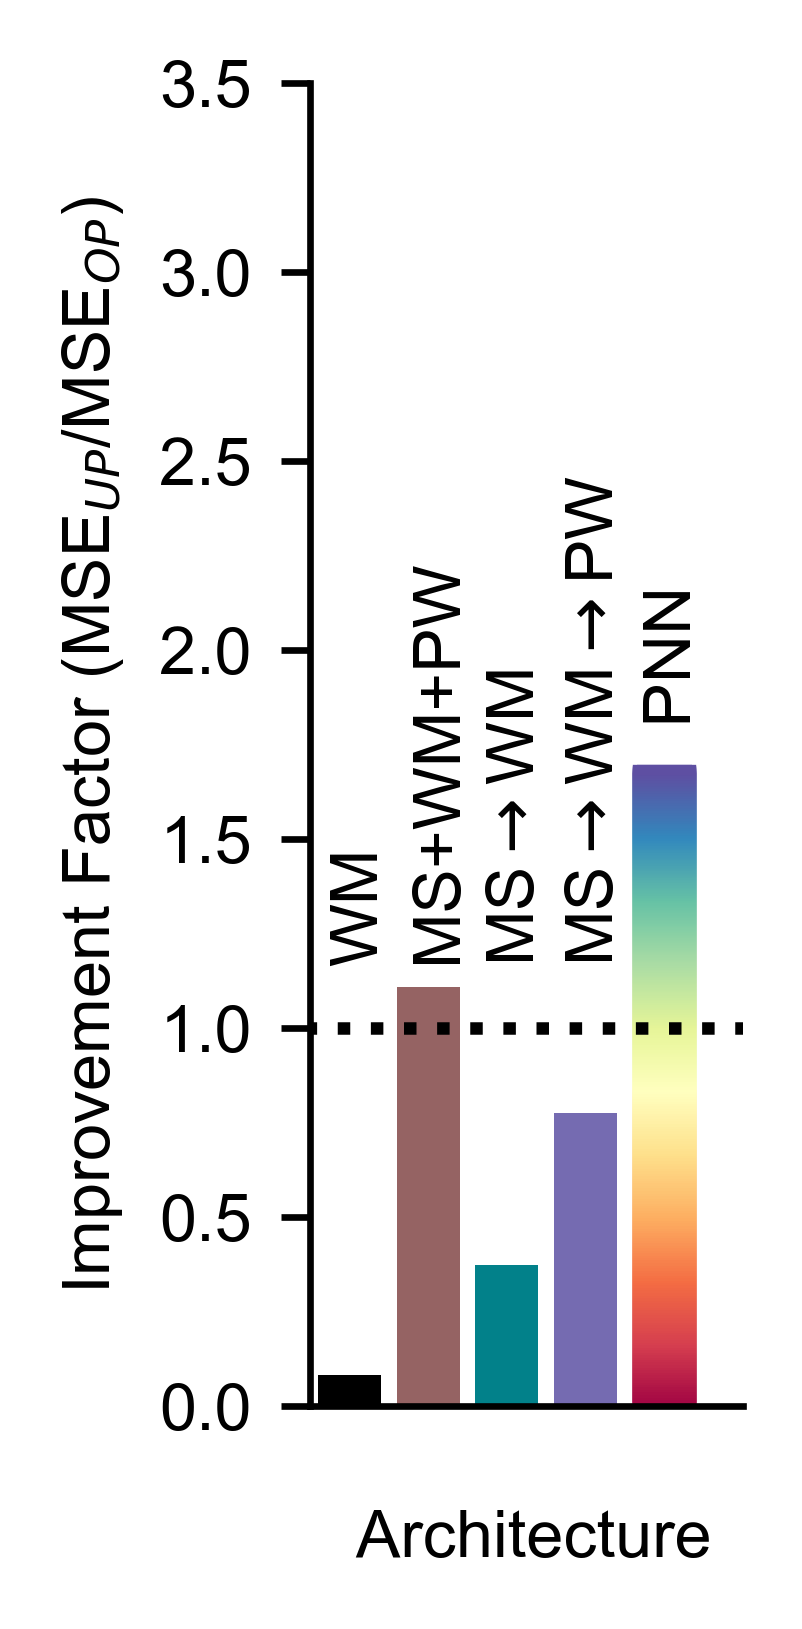

In [3]:
#Bar plot specific task. Just mem

from matplotlib import pyplot as plt, patches
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"]=8
plt.rcParams['figure.dpi'] = 600


group1 = ['Single\WM']
group2 = ['Parallel\Pall']
group3 = ['Series\S34'] # MS->WM
group4 = ['Series\S45'] # MS->WM->PW
group5= ['PNN\All'] # PNN

groupnames = [r'WM' ,r'MS+WM+PW',r'MS$\rightarrow$WM',
             r'MS$\rightarrow$WM$\rightarrow$PW',r' PNN']
groups = [group1,group2,group3,group4,group5]

clist = ['k',#Single
          '#956363',#Parallel

         '#02818A',#MS->WM
          
          '#756BB1',#MS to PW to WM
         'r'
          
         ]
for trainsize in [50,100]:
    for alpha in [0]:
        iterations = 500
        seeds = 50

        cm = 1/2.54
        fig,ax = plt.subplots(1,1,figsize=(3.5*cm,7*cm))
        c_list = ['k','#956363','#007f83','#756bb1','#e75347']
        ID=0
        j=-1
        bar=0
        for nets in groups:
            
            
            for net in nets:
                j+=1
                data_folder = os.path.join(base,r'Data_results\Mackey_Glass',net)
                print(data_folder)
                data,inputs = load_data(data_folder,250)
                savdir = os.path.join(data_folder,'OP')

                tasks = [0,1,2,3,4,5]
                if net == 'PNN\All':
                    iterations=5000
                TrMSEmeanall = np.zeros((iterations-1))
                TeMSEmeanall = np.zeros((iterations-1))
                TrMSEstdall = np.zeros((iterations-1))
                TeMSEstdall = np.zeros((iterations-1))
                if net != 'PNN\All' or trainsize!=100:
                    for task in tasks:

                        TrMSE =    np.load(os.path.join(savdir, 'MSETr_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                                 .format(alpha,task,seeds,iterations,trainsize)))
                        TeMSE =    np.load(os.path.join(savdir,'MSETe_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                 .format(alpha,task,seeds,iterations,trainsize)))
                        x =    np.load(os.path.join(savdir,'Channels_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                 .format(alpha,task,seeds,iterations,trainsize)))
                        #print(x)
                        TrMSEmean = np.mean(np.mean(TrMSE,axis=2),axis=0)[1:]
                        TrMSEstd = np.std(np.mean(TrMSE,axis=2),axis=0)[1:]
                        TeMSEmean = np.mean(np.mean(TeMSE,axis=2),axis=0)[1:]
                        TeMSEstd = np.std(np.mean(TeMSE,axis=2),axis=0)[1:]


                        TrMSEmeanall+=TrMSEmean/len(tasks)
                        TeMSEmeanall+=TeMSEmean/len(tasks)
                        TrMSEstdall+=TrMSEstd/len(tasks)
                        TeMSEstdall+=TeMSEstd/len(tasks)
                    TrMSEstdall = TrMSEstdall/(50**0.5)
                    TeMSEstdall = TeMSEstdall/(50**0.5)
                    x = x[0,1:,0]
                else:
                    TrMSE = np.load(os.path.join(savdir, 'MSETr_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                                 .format(alpha,seeds,iterations,trainsize)))
                    TeMSE = np.load(os.path.join(savdir, 'MSETe_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                                 .format(alpha,seeds,iterations,trainsize)))
                    x = np.load(os.path.join(savdir, 'Channels_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                                 .format(alpha,seeds,iterations,trainsize)))
                    for task in tasks:
                        TrMSEmean = np.mean(np.mean(TrMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                        TrMSEstd = np.std(np.mean(TrMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                        TeMSEmean = np.mean(np.mean(TeMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                        TeMSEstd = np.std(np.mean(TeMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]


                        TrMSEmeanall+=TrMSEmean/len(tasks)
                        TeMSEmeanall+=TeMSEmean/len(tasks)
                        TrMSEstdall+=TrMSEstd/len(tasks)
                        TeMSEstdall+=TeMSEstd/len(tasks)
                    TrMSEstdall = TrMSEstdall/(50**0.5)
                    TeMSEstdall = TeMSEstdall/(50**0.5) 

                    x = x[0,1:,0,0]
                if len(np.where(np.array(x)<50)[0])!=0:


                    
                    minUP = np.min(TeMSEmeanall[np.where(np.array(x)<trainsize)])
                    minOP = np.min(TeMSEmeanall[np.where(np.array(x)>trainsize)])

                    diff = minUP/minOP
                    
                    if net!='PNN\All':
                        ax.bar(ID,diff,color=clist[bar])
                    
                    else:
                        yspace = np.linspace(0,diff,1000)
                        colormap = plt.cm.Spectral #nipy_spectral, Set1,Paired   
                        colors = [colormap(i) for i in np.linspace(0, 1,1000)]
                        for y in range(len(yspace)):
                            rectangle = patches.Rectangle((ID-0.35,yspace[y]), 0.7, diff/1000, edgecolor=colors[y],
                                                            facecolor=colors[y], linewidth=1)
                            ax.add_patch(rectangle)
                            #ax.Rect((ID,ypace[y]),1,diff/1000,c=[colors[y/1000]])
                    bar+=1
                    if diff>1:
                        ax.text(ID-0.25,diff+0.1,groupnames[j],rotation=90)
                    else:
                        ax.text(ID-0.25,1+0.2,groupnames[j],rotation=90)
                
                ID+=1
            #ID+=1
        ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
        ax.set_ylabel('Improvement Factor (MSE$_{UP}$/MSE$_{OP}$)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.plot([-1,ID],[1,1],c='k',ls=':')
        ax.set_ylim(0,3.5)
        ax.set_xlim(-0.5,ID)
        ax.set_xlabel('\n Architecture')
        #ax.spines['left'].set_position('zero')
        #ax.spines['bottom'].set_position('one')
        
        plt.tight_layout()
        #plt.savefig(os.path.join(savdirnice,'paperthinAll_tasks_barreduced_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.png'
         #                                        .format(alpha,future,seeds,iterations,trainsize)))
           

Data_results\Mackey_Glass\Single\WM
Data_results\Mackey_Glass\Parallel\Pall
Data_results\Mackey_Glass\Series\S34
Data_results\Mackey_Glass\Series\S45
Data_results\Mackey_Glass\PNN\All
File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy
Data_results\Mackey_Glass\Single\WM
Data_results\Mackey_Glass\Parallel\Pall
Data_results\Mackey_Glass\Series\S34
Data_results\Mackey_Glass\Series\S45
Data_results\Mackey_Glass\PNN\All
File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy


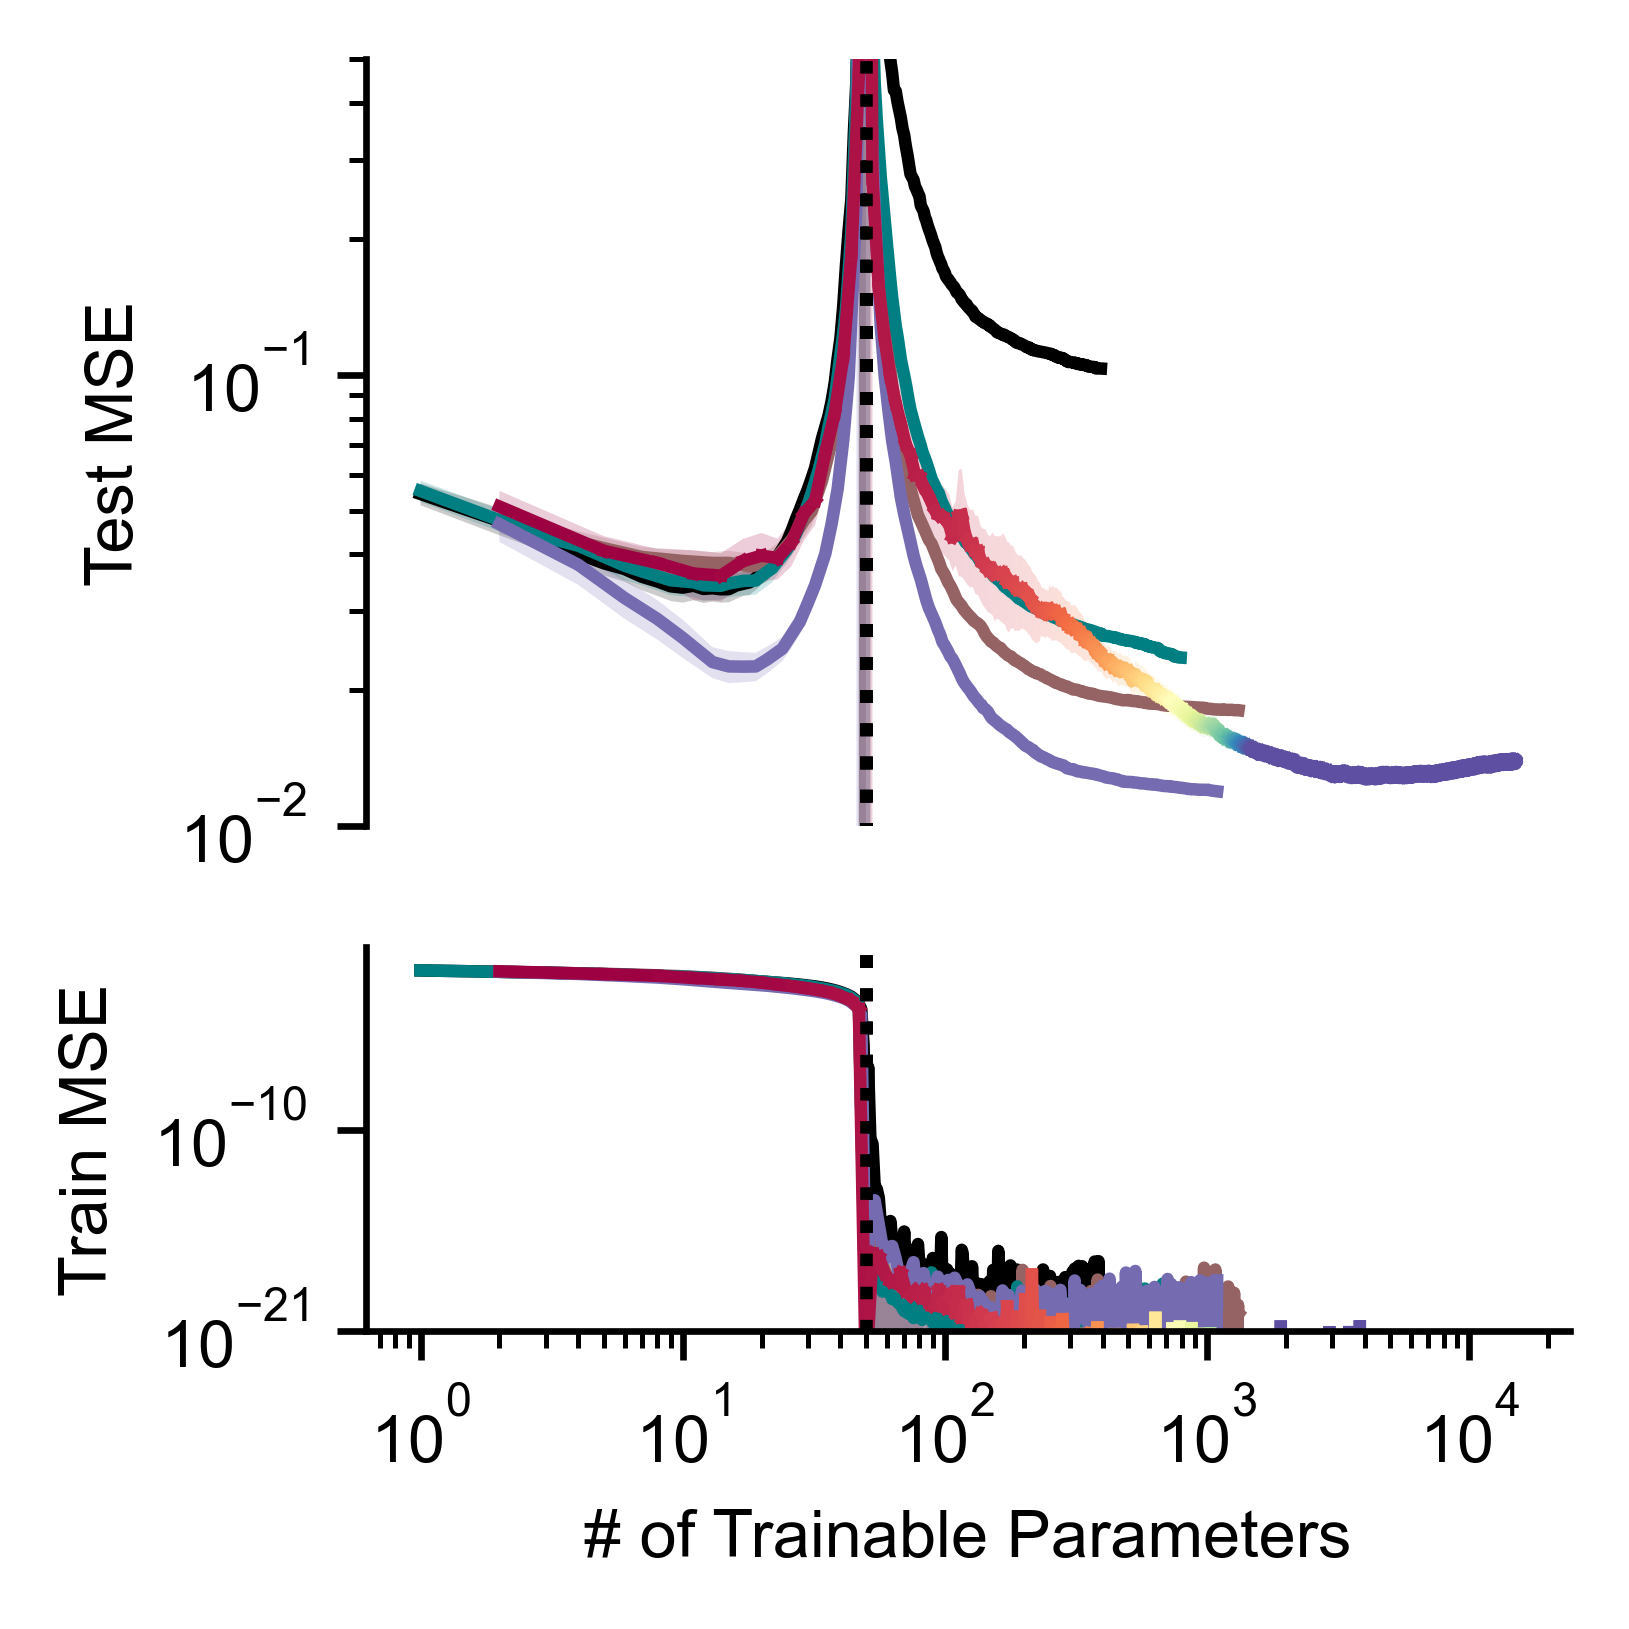

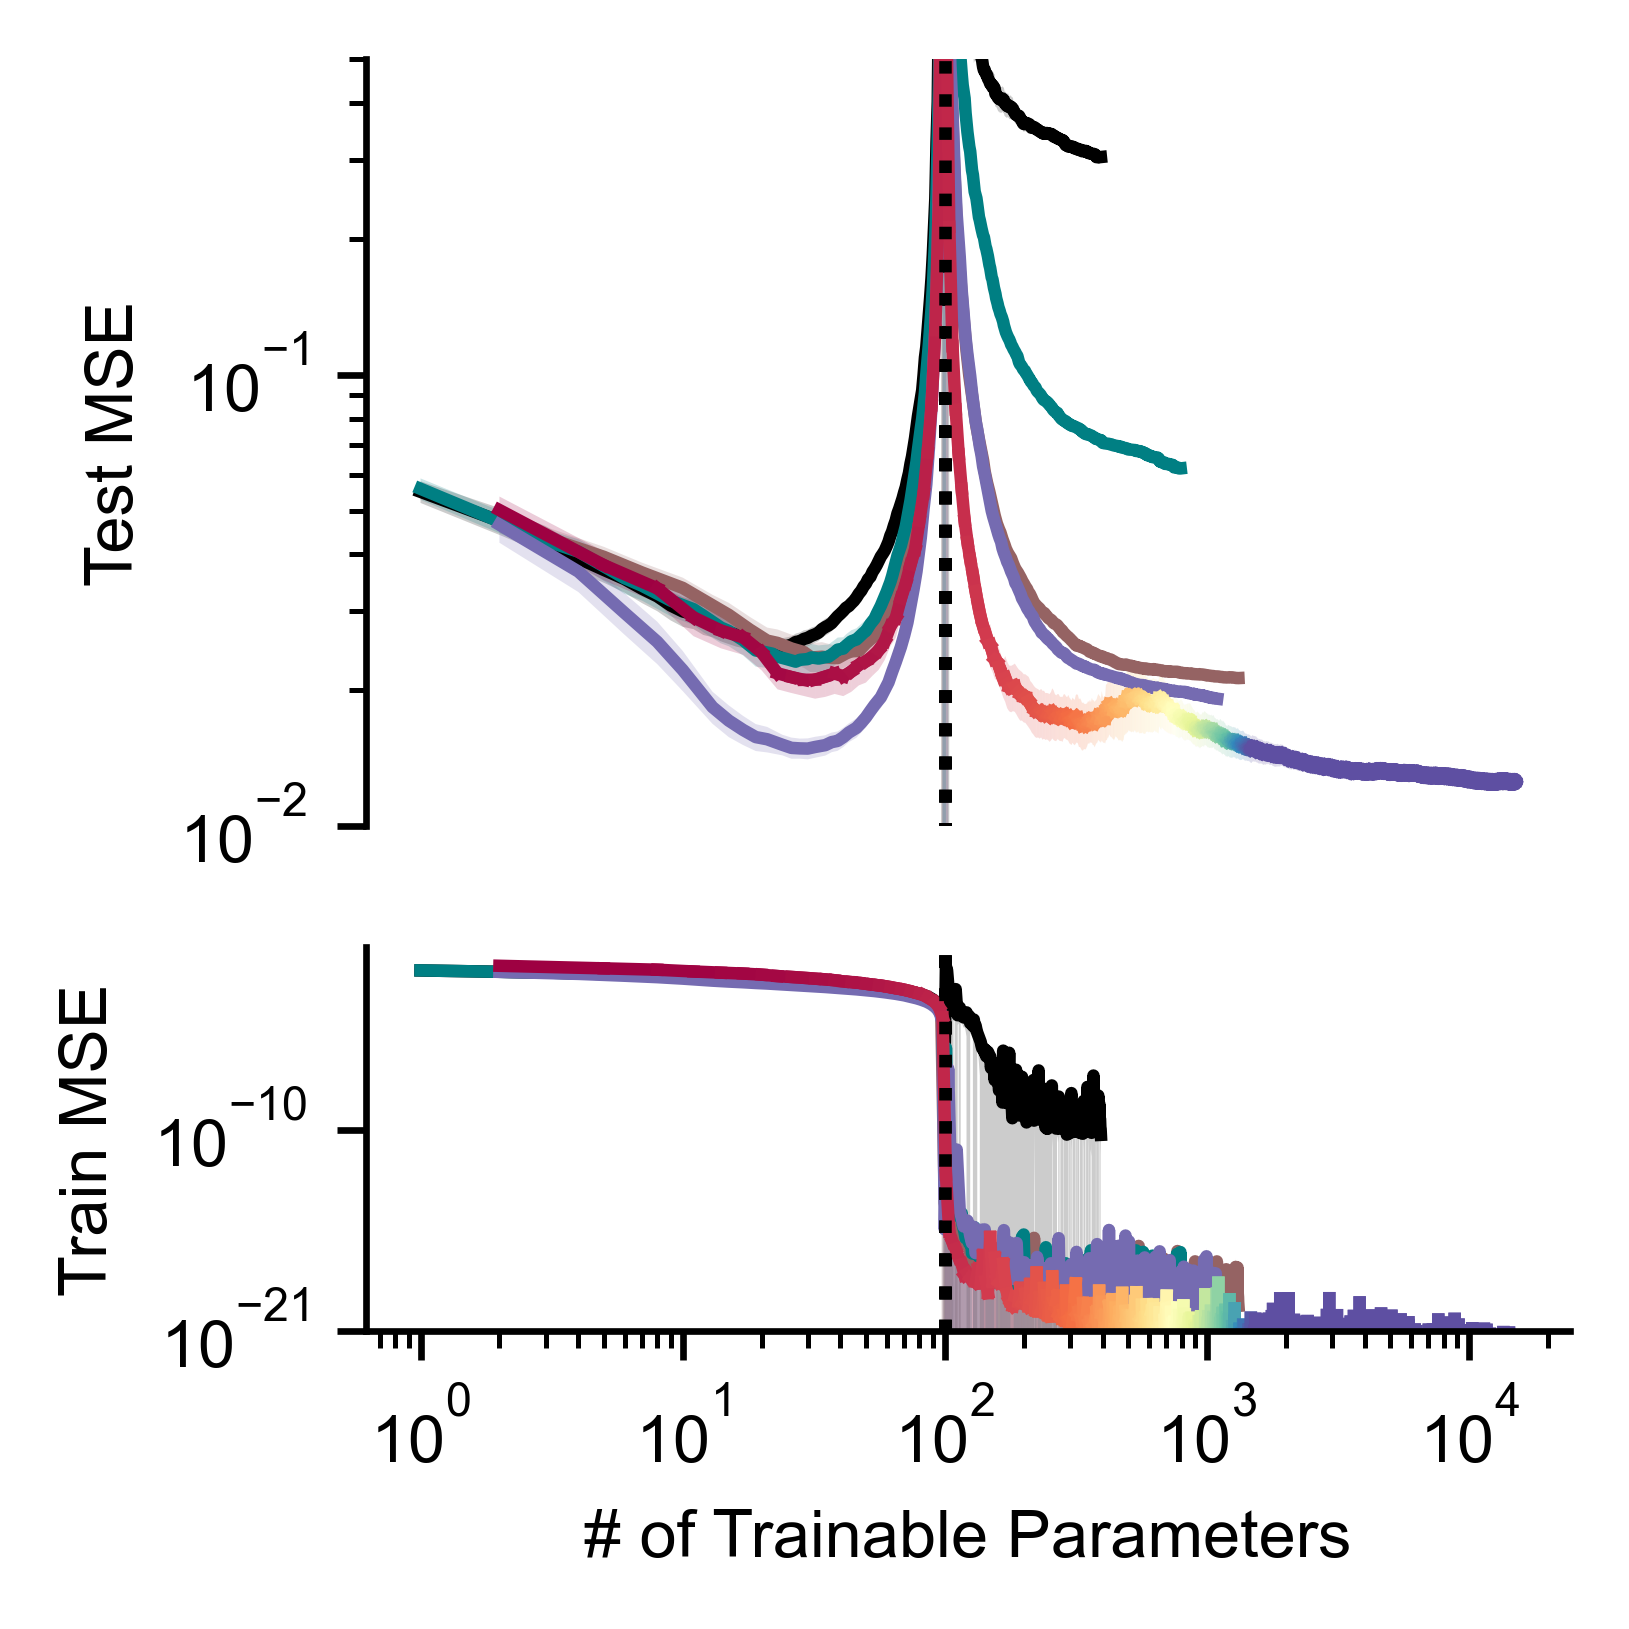

In [8]:
#oldformat. All tasks


plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"]=8
plt.rcParams['figure.dpi'] = 600

nets = ['Single\WM','Parallel\Pall','Series\S34','Series\S45','PNN\All']

for trainsize in [50,100]:
    for alpha in [0]:
        #taskID = 7
        #alpha = 1e-4
        iterations = 500
        seeds = 50
        #trainsize = 50
        cm = 1/2.54
        fig,ax = plt.subplots(2,1,figsize=(7*cm,7*cm),height_ratios=[2,1])
        left, bottom, width, height = [0.7, 0.7, 0.3, 0.25]
        ax2 = fig.add_axes([left, bottom, width, height])
        c_list = ['k','#956363','#007f83','#756bb1','#e75347']
        ID=0
        tasks = [0,1,2,3,4,5]
        for net in nets:
            data_folder = os.path.join(base,r'Data_results\Mackey_Glass',net)
            print(data_folder)
            data,inputs = load_data(data_folder,250)

            savdir = os.path.join(data_folder,'OP')
            if net == 'PNN\All':
                iterations = 5000
            else:
                iterations=500
            TrMSEmeanall = np.zeros((iterations-1))
            TeMSEmeanall = np.zeros((iterations-1))
            TrMSEstdall = np.zeros((iterations-1))
            TeMSEstdall = np.zeros((iterations-1))
            if net != 'PNN\All' or trainsize!=100:
                for task in tasks:

                    TrMSE =    np.load(os.path.join(savdir, 'MSETr_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                             .format(alpha,task,seeds,iterations,trainsize)))
                    TeMSE =    np.load(os.path.join(savdir,'MSETe_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                             .format(alpha,task,seeds,iterations,trainsize)))
                    x =    np.load(os.path.join(savdir,'Channels_alpha_{}_task_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                             .format(alpha,task,seeds,iterations,trainsize)))
                    #print(x)
                    TrMSEmean = np.mean(np.mean(TrMSE,axis=2),axis=0)[1:]
                    TrMSEstd = np.std(np.mean(TrMSE,axis=2),axis=0)[1:]
                    TeMSEmean = np.mean(np.mean(TeMSE,axis=2),axis=0)[1:]
                    TeMSEstd = np.std(np.mean(TeMSE,axis=2),axis=0)[1:]

                    
                    TrMSEmeanall+=TrMSEmean/len(tasks)
                    TeMSEmeanall+=TeMSEmean/len(tasks)
                    TrMSEstdall+=TrMSEstd/len(tasks)
                    TeMSEstdall+=TeMSEstd/len(tasks)
                TrMSEstdall = TrMSEstdall/(50**0.5)
                TeMSEstdall = TeMSEstdall/(50**0.5)
                x = x[0,1:,0]
            else:
                TrMSE = np.load(os.path.join(savdir, 'MSETr_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                             .format(alpha,seeds,iterations,trainsize)))
                TeMSE = np.load(os.path.join(savdir, 'MSETe_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                             .format(alpha,seeds,iterations,trainsize)))
                x = np.load(os.path.join(savdir, 'Channels_alltask_alpha_{}_ntrials_{}_iter_{}_train_{}_test_50_crossval_5.npy'
                                                             .format(alpha,seeds,iterations,trainsize)))
                for task in tasks:
                    TrMSEmean = np.mean(np.mean(TrMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                    TrMSEstd = np.std(np.mean(TrMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                    TeMSEmean = np.mean(np.mean(TeMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]
                    TeMSEstd = np.std(np.mean(TeMSE[:,:,:,task]*6/50,axis=2),axis=0)[1:]

                    
                    TrMSEmeanall+=TrMSEmean/len(tasks)
                    TeMSEmeanall+=TeMSEmean/len(tasks)
                    TrMSEstdall+=TrMSEstd/len(tasks)
                    TeMSEstdall+=TeMSEstd/len(tasks)
                TrMSEstdall = TrMSEstdall/(50**0.5)
                TeMSEstdall = TeMSEstdall/(50**0.5) 
                
                x = x[0,1:,0,0]
            if net!='PNN\All':
                ax[0].semilogy(x,TeMSEmeanall,c=c_list[ID],label = net.split('\\')[1])
                ax[1].semilogy(x,TrMSEmeanall,c=c_list[ID])
                ax[0].fill_between(x,TeMSEmeanall-2*TeMSEstdall,TeMSEmeanall+2*TeMSEstdall,alpha=0.2,facecolor=c_list[ID])
                ax[1].fill_between(x,TrMSEmeanall-2*TrMSEstdall,TrMSEmeanall+2*TrMSEstdall,alpha=0.2,facecolor=c_list[ID])
                    
            else:
                yspace = np.linspace(0,len(TeMSEmeanall),len(TeMSEmeanall))
                colormap = plt.cm.Spectral #nipy_spectral, Set1,Paired   
                colors = [colormap(i) for i in np.linspace(0, 10,len(TeMSEmeanall))]
                for i in range(len(TeMSEmeanall)):
                    ax[0].plot(x[i:i+2],TeMSEmeanall[i:i+2],c=colors[i])
                    ax[1].plot(x[i:i+2],TrMSEmeanall[i:i+2],c=colors[i])
                    ax[0].fill_between(x[i:i+2],TeMSEmeanall[i:i+2]-2*TeMSEstdall[i:i+2],TeMSEmeanall[i:i+2]+2*TeMSEstdall[i:i+2],alpha=0.2,facecolor=colors[i])
                    ax[1].fill_between(x[i:i+2],TrMSEmeanall[i:i+2]-2*TrMSEstdall[i:i+2],TrMSEmeanall[i:i+2]+2*TrMSEstdall[i:i+2],alpha=0.2,facecolor=colors[i])

            ax[0].plot([trainsize,trainsize],[1e-50,1000],c='k',ls=':')
            ax[1].plot([trainsize,trainsize],[1e-50,1000],c='k',ls=':')
            
           
            ax2.semilogy(x,TeMSEmeanall,c=c_list[ID],label = net.split('\\')[1])

            
                
            ax[0].set_xscale('log')
            ax[1].set_xscale('log')
            ax[0].set_ylabel('Test MSE')
            ax[1].set_ylabel('Train MSE')
            ax[0].set_xticks([])
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[1].set_xlabel('# of Trainable Parameters')
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)
            ax[0].spines['left'].set_visible(True)
            ax[1].spines['top'].set_visible(False)
            ax[1].spines['right'].set_visible(False)
            ax[1].spines['bottom'].set_visible(True)
            ax[1].spines['left'].set_visible(True)
            ax2.set_xscale('log')
            ax2.set_xlim(50,15000)
            ax2.set_ylim(10e-3,2e-1)
            ax2.set_xlabel('# of Trainable Parameters')
            ax2.set_ylabel('Test MSE')
            
            ID+=1
        ax[0].set_ylim(10e-3,.5)
        ax[1].set_ylim(10e-22,10e-1)
        ax2.remove()
        plt.tight_layout()

       
            